## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

## Import df

In [ ]:
df = pd.read_csv('Airline_review_original.csv')
# Dropping first two column of entry ID and airline_name
df = df.iloc[:, 2:]

- [ ] Remove the block below prior to submission, personal notes

- Do not need to handle "Overall_Rating" = 'n' as in Kaggle since we are ignoring this column for its subjectivity.
- All NaN values has been replaced with the mean in the same column. 
    - In Kaggle, NaN is replaced by the median corresponding to the "Overall_Rating" for each column.

*Disclaimer that running of sentiment analysis will take much longer for our dataset as Kaggle's version used only a subset of the entire dataset.

## Data Cleaning

Edits have been made that are slightly different from Notebook 1.ipynb, with changes detailed. 

In [ ]:
# Replace empty and None values with "Other Type of Travellers"
df['Type Of Traveller'].fillna('Other Type of Travellers', inplace=True)

# Dropping [Aircraft. Verfied, Route, Overall_Rating] since it has no value to our research
df.drop('Aircraft', axis=1, inplace=True)
df.drop('Verified', axis=1, inplace=True)
df.drop('Route', axis=1, inplace=True)
df.drop('Overall_Rating', axis=1, inplace=True)

# Dropping 'Date Flown' as well as we assume 'Date Flown' and 'Review Date' to be in the same timeframe, hence keeping only one
df.drop('Date Flown', axis=1, inplace=True)

# Replacing nan values across the individual ratings columns with same scales
columns_to_fill = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 
                   'Ground Service', 'Inflight Entertainment', 
                   'Wifi & Connectivity', 'Value For Money']

for column in columns_to_fill:
    df[column].fillna(int(df[column].mean()), inplace=True)

# Creating a new column that sums up the individual ratings
df['Total Score'] = df[columns_to_fill].sum(axis=1)

# CHANGE 1. Review Date is NOT dropped

# b. Split the column by comma (',')
df['Review Date'] = df['Review Date'].str.split(' ').str[2]

# c. Convert to datetime
df['Review Date'] = pd.to_datetime(df['Review Date'], format='%Y')

# CHANGE 2. separation into 2 new df is done AFTER sentiment analysis & changing "Recommended" to binary values

# CHANGE 3. 
# Creating labels for pre- and post-covid 
# Instead of separating into 2 datasets

# 0 : Pre-covid 
# 1 : Post-covid
df['Review Period'] = [0 if row < 2020 else 1 for row in df['Review Date'].dt.year]

## Download NLP package

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# download nltk corpus (uncomment if running for the first time)
'''
nltk.download([
"names",
"stopwords",
"vader_lexicon",
"punkt",
"wordnet"
])

nltk.download('all')
'''

'\nnltk.download([\n"names",\n"stopwords",\n"vader_lexicon",\n"punkt",\n"wordnet"\n])\n\nnltk.download(\'all\')\n'

## Text Preprocessing for "Review" attribute

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# create preprocess_text function (~approx 40min)
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

start_time = dt.datetime.now()
print("Started text preprocessing at ", start_time)
df['Review'] = df['Review'].apply(preprocess_text)
end_time = dt.datetime.now()
elapsed_time = end_time - start_time
print("Finished text preprocessing at ", end_time)
print ("Text preprocessing completed. Elapsed time: ", elapsed_time)

Started text preprocessing at  2023-10-22 21:01:46.168720
Finished text preprocessing at  2023-10-22 21:06:37.456738
Text preprocessing completed. Elapsed time:  0:04:51.288018


## Get "sentiment" & "sentiment_score"

Utilising pre-trained VADER sentiment analysis tool, 2 new attributes will be added to df

| Attribute | Data Type | Possible values |
| --- | --- | --- |
| sentiment | Binary | Positive(1) / Negative(0) |
| sentiment_score | Continuous| [-1,1] | 

In [ ]:
# create get_sentiment function (~approx 15min)
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    # initialize NLTK sentiment analyzer
    scores = analyzer.polarity_scores(text)
    sentiment = 0
    if scores['pos'] > 0 and scores['pos'] > scores['neg']:
        sentiment = 1
    return sentiment

def get_compound_sentiment(text):
    # initialize NLTK sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    sentiment = scores['compound']
    return sentiment

start_time = dt.datetime.now()
print("Started sentiment scoring at ", start_time)
df['sentiment'] = df['Review'].apply(get_sentiment)
df['sentiment_score'] = df['Review'].apply(get_compound_sentiment)

end_time = dt.datetime.now()
elapsed_time = end_time - start_time
print("Finished sentiment scoring at ", end_time)
print ("Sentiment scoring completed. Elapsed time: ", elapsed_time)

Started sentiment scoring at  2023-10-22 21:06:37.479563
Finished sentiment scoring at  2023-10-22 21:09:18.157203
Sentiment scoring completed. Elapsed time:  0:02:40.677640


In [ ]:
# rewriting contents of csv file with new df including sentiment
df.to_csv('Airline_review.csv', index=False)

'sentiment' attribute

### Distribution

General Timeframe

In [ ]:
(df['sentiment'].value_counts() / df['sentiment'].count() *100)

1    54.348108
0    45.651892
Name: sentiment, dtype: float64

More than 54% expressed positive sentiments in the entire timeframe of the dataset.

Pre- and Post-covid

In [ ]:
sentiment_group = df.groupby(['Review Period', 'sentiment'], as_index = True)['sentiment'].count()
sentiment_group

Review Period  sentiment
0              0            4198
               1            7230
1              0            6380
               1            5363
Name: sentiment, dtype: int64

Pre-covid, there are more positive sentiments.
Post-covid, there are more negative sentiments.

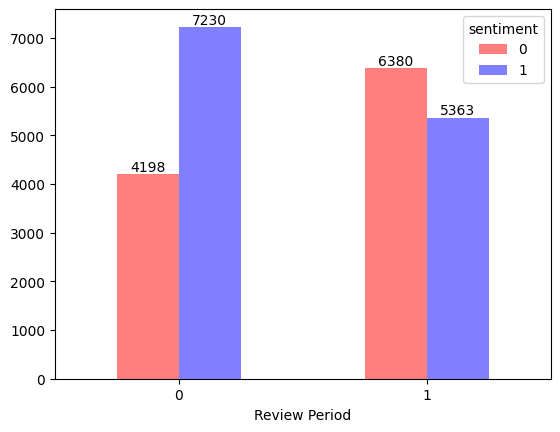

In [ ]:
ax = sentiment_group.unstack().plot(kind='bar', alpha=0.5, rot=0, color=['red','blue'])
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
# determining class imbalance for recommended
df.groupby(['Review Period', 'Recommended'])['Recommended'].count()

Review Period  Recommended
0              no             6549
               yes            4879
1              no             8815
               yes            2928
Name: Recommended, dtype: int64

### Confusion Matrix

Compare attributes "Recommend" with the created attribute "Sentiment" using a confusion matrix

1. Transform "Recommend" attribute from text to binary values
2. Separate into 2 new df: pre_covid and post_covid
3. Calculate confusion matrix
    3.1. General timeframe
    3.2. Pre-covid
    3.3. Post-covid

In [ ]:
# 1. Transform 'Recommended' to binary 0/1 values to calculate confusion matrix
def set_recommended(value):
    result = 0
    if value == "yes":
        result = 1
    return result

df['recommended_binary'] = df['Recommended'].apply(set_recommended)

In [ ]:
# 2. Separate the pre-covid and post-covid into two new data frames
pre_covid = df[df['Review Date'].dt.year < 2020]
post_covid = df[df['Review Date'].dt.year >= 2020]

[[10074  5290]
 [  504  7303]]


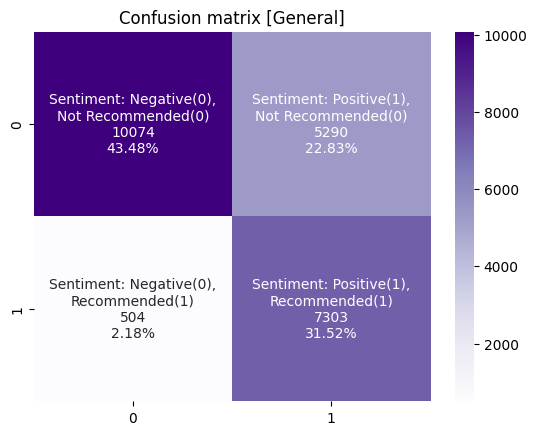

[[3906 2643]
 [ 292 4587]]


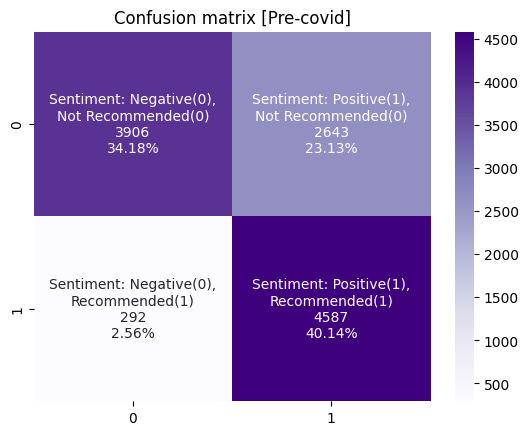

[[6168 2647]
 [ 212 2716]]


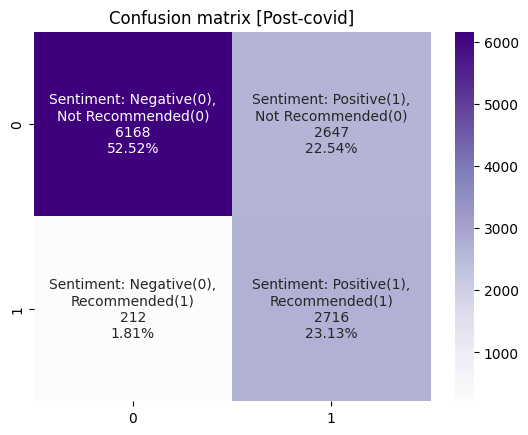

In [ ]:
# 3.1. Loop for diff timeframes

dfs = {'General': df, 
        'Pre-covid': pre_covid, 
        'Post-covid': post_covid}

for k,v in dfs.items():
    cf_matrix = confusion_matrix(v['recommended_binary'], v['sentiment'])
    print(cf_matrix) #list

    group_names = ["Sentiment: Negative(0),\nNot Recommended(0)",
                   "Sentiment: Positive(1),\nNot Recommended(0)",
                   "Sentiment: Negative(0),\nRecommended(1)",
                   "Sentiment: Positive(1),\nRecommended(1)"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')
    plt.title('Confusion matrix ['+k+']')
    plt.show()

General Timeframe                                                                                                                                                                                          - 31.52% - - 31.52% of the reviews are positive (1) both in terms of their sentiment and Recommended status ('yes')
- 43.48% of the reviews are negative (0) both in terms of their sentiment (negative) and Recommended status ('no')

However, the other 2 quadrants making up 25.0% of reviews may be confusive. 
- 22.83% expressed positive (1) sentiment, yet do not recommend it
- 2.18% expressed negative (0) sentiment, yet *recommends* it

This is acceptable if we were to put ourselves in the shoes of the passengers. 
- We may leave POSITIVE reviews, but do NOT recommend it as we believe that there are better options. 
- Conversely, we may leave NEGATIVE reviews, but still RECOMMEND the airline if we think that it is the best bet that we have. 

> "sentiment_score" attribute

### Distribution

In [ ]:
for k,v in dfs.items():
    fig = px.histogram(v, x="sentiment_score", marginal="rug",
                    title='Distribution of sentiment_score ['+k+']',
                    color_discrete_sequence=px.colors.qualitative.Prism)
    fig.show()

> "recommended_binary" attribute

In [ ]:
print('General timeframe')
(df['recommended_binary'].value_counts() / df['recommended_binary'].count()) *100

General timeframe


0    66.307022
1    33.692978
Name: recommended_binary, dtype: float64

While 66.31% of reviews have "recommened_binary"=0 (do not recommend), 
the distribution of sentiment_score is left-skewed and show that most reviews have a positive sentiment (>=0.5) instead.

As previously explained, this is acceptable given that:
- We may leave POSITIVE reviews, but do NOT recommend it as we believe that there are better options. 
- Conversely, we may leave NEGATIVE reviews, but still RECOMMEND the airline if we think that it is the best bet that we have. 

In [ ]:
print('\nPre- and Post-covid')
df.groupby(['Review Period', 'recommended_binary'])['recommended_binary'].count()


Pre- and Post-covid


Review Period  recommended_binary
0              0                     6549
               1                     4879
1              0                     8815
               1                     2928
Name: recommended_binary, dtype: int64

### Box Plot

In [ ]:
for k,v in dfs.items():
    fig = make_subplots(rows=3, cols=1, subplot_titles=('<b>Relations between sentiment_score and Recommended</b>',
                                                        '<b>Relations between sentiment_score and Type Of Traveller</b>',
                                                        '<b>Relations between sentiment_score and Seat Type</b>'
                                                    ))

    fig.add_trace(go.Box(y=v['sentiment_score'], x=v['Recommended']), row=1, col=1)
    fig.add_trace(go.Box(y=v['sentiment_score'], x=v['Type Of Traveller']), row=2, col=1)
    fig.add_trace(go.Box(y=v['sentiment_score'], x=v['Seat Type']), row=3, col=1)
            
    # Update visual layout
    fig.update_layout(
        showlegend=False,
        width=800,
        height=500,
        autosize=False,
        template="plotly_white",
        colorway=px.colors.qualitative.Prism,
        title=k
    )

    # update font size at the axes
    fig.update_coloraxes(colorbar_tickfont_size=10)
    # Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
    fig.update_annotations(font_size=12)
    # Reduce opacity
    fig.update_traces(opacity=0.75)
    fig.show()

### Correlation

In [ ]:
dfs_numeric = {'General': df._get_numeric_data(), 
        'Pre-covid': pre_covid._get_numeric_data(), 
        'Post-covid': post_covid._get_numeric_data()}
cmap_dict = {'General': sns.diverging_palette(250, 15, n=9, as_cmap=True),
            'Pre-covid': sns.diverging_palette(150, 275, n=9, as_cmap=True), 
            'Post-covid': sns.diverging_palette(100, 20, sep=10, as_cmap=True)}

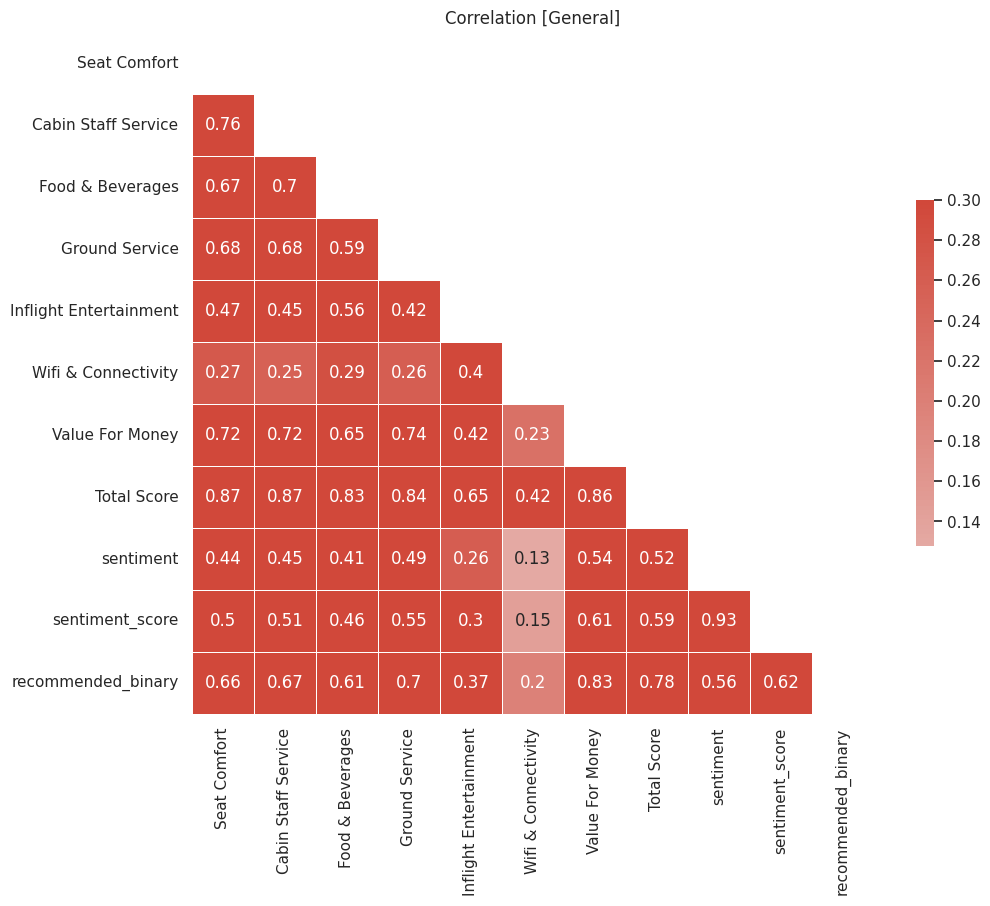

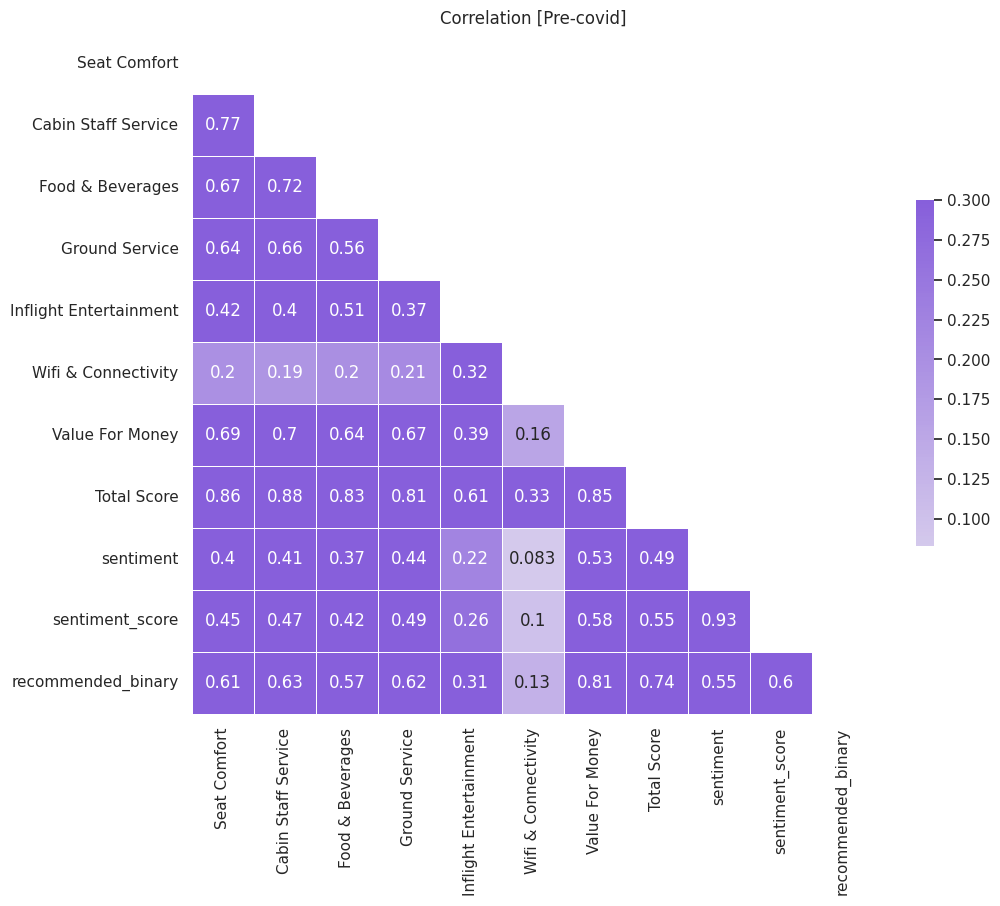

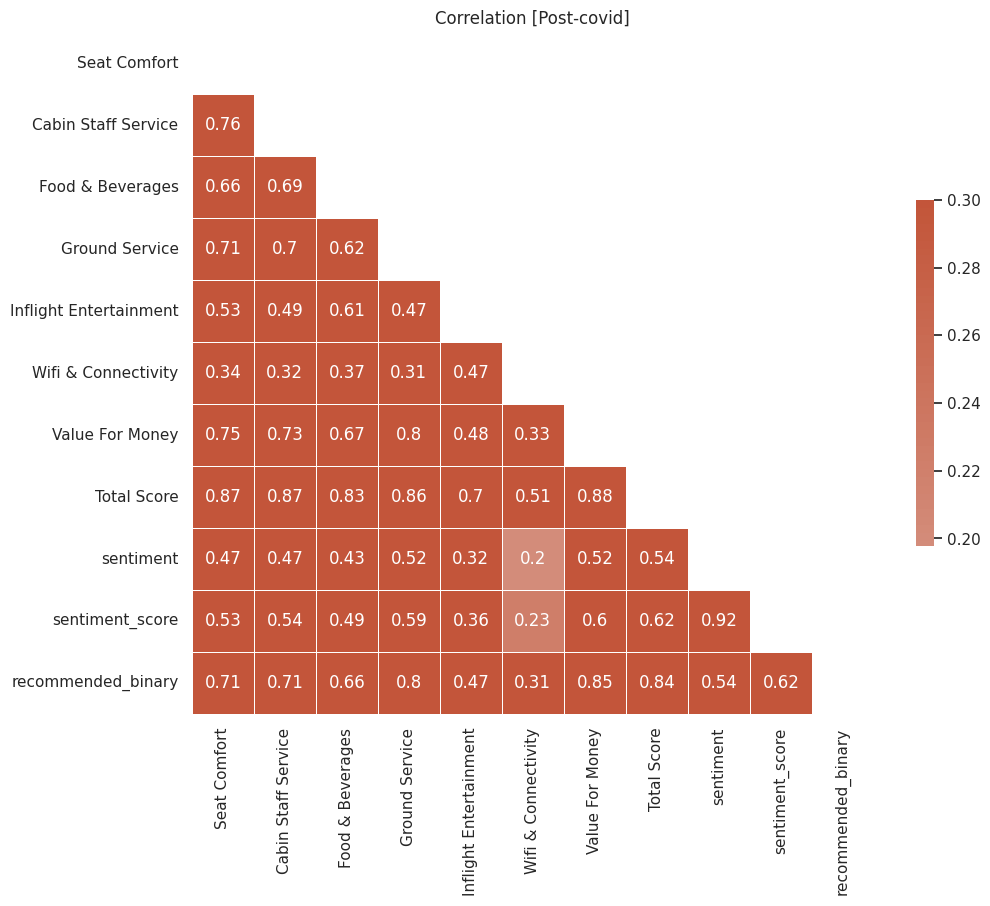

In [ ]:
sns.set_theme(style="white")

for k,v in dfs_numeric.items():
    # Compute the correlation matrix for numeric features
    corr = v.drop('Review Period',axis='columns').corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap_dict[k], vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Correlation ['+k+']')

There is medium to strong correlation of "sentiment_score" attribute with the following attributes regardless of timeframes.
- Value For Money
- Total Score
- Ground Services

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e2d7258-be81-4486-bc85-234b0cc7a7d6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>